### Машинное Обучение

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 1 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [1]:
import numpy as np
import pandas as pd
#import scipy.stats

from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1
    
    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split, self.max_depth, self.num_class, self.criterion, self.__y_criterion, \
        self.feature_importances_ = min_samples_split, max_depth, None, criterion, 0, None
        
        def __misclass(y):
            if y.size <= 1:
                return 1.0
            else:
                return 1.0 - max(np.bincount(y))/y.size

        def __gini(y):
            return 1.0 - sum(np.square(np.bincount(y)/y.size))

        def __entropy(y):
            if y.size <= 1:
                return 0
            ps = np.bincount(y) / y.size
            return -sum([p * np.log2(p) for p in ps if p > 0])
       
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        if criterion == 'gini':
            self.calc_criterion = __gini
        elif self.criterion == 'misclass':
            self.calc_criterion = __misclass
        elif self.criterion == 'entropy':
            self.calc_criterion = __entropy
        else:
            raise NameError("No such criterion")

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __calc_Q(self, y, i):
        y_l, y_r = y[0:i], y[i:y.shape[0]]
        #Q = self.__y_criterion - (self.calc_criterion(y_l)*y_l.shape[0] + self.calc_criterion(y_r)*y_r.shape[0])/y.shape[0]
        return self.__y_criterion-(self.calc_criterion(y_l)*y_l.shape[0] + self.calc_criterion(y_r)*y_r.shape[0])/y.shape[0] #Q
  
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        opt_feature, opt_split, max_Q, self.__y_criterion = 0, x[0, 0], self.__calc_Q(y, 0), self.calc_criterion(y)
        #sum_y = np.sum(y)
        #sum_square_y = np.sum(np.square(y))
        for feature_idx in range(x.shape[1]):
            order = np.argsort(x[:, feature_idx])
            if np.unique(x[:, feature_idx]).size == 1: # Проверяем на уникальность
                continue
            srt_x, srt_y, y_prev_idx, same_val = x[order, :], y[order], 0, False
            for i in range(1, x.shape[0] - 1):
                if srt_y[i] == srt_y[y_prev_idx]:
                    same_val = True
                    continue
                y_prev_idx, same_val, new_Q = i, False, self.__calc_Q(srt_y, i)
                if new_Q > max_Q:
                    max_Q, opt_feature, opt_order = new_Q, feature_idx, order
                    opt_split = (srt_x[i - 1, opt_feature] + srt_x[i, opt_feature])/2
        return opt_feature, opt_split, max_Q
    '''
    def __leaf_class_predict(self, y):
        return np.argmax(np.bincount(y))
    '''
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if (depth >= self.max_depth) or (y.shape[0] < self.min_samples_split):
            pred = np.argmax(np.bincount(y))
            prob = np.sum(y == pred)/y.shape[0]
            self.tree[node_id] = (self.LEAF_TYPE, pred, prob) #new_node
        else:
            opt_feature, opt_split, max_Q = self.__find_threshold(x, y)
            reord_feat = x[:, opt_feature]
            l_idx = reord_feat < opt_split
            r_idx = ~l_idx # reord_feat >= opt_split
            if y[l_idx].shape[0] < self.min_samples_split or y[r_idx].shape[0] < self.min_samples_split:
                pred = np.argmax(np.bincount(y))
                prob = np.sum(y == pred)/y.shape[0]
                self.tree[node_id] = (self.LEAF_TYPE, pred, prob)
            else:
                self.tree[node_id] = (self.NON_LEAF_TYPE, opt_feature, opt_split)
                self.__fit_node(x[l_idx], y[l_idx], 2 * node_id + 1, depth + 1)
                self.__fit_node(x[r_idx], y[r_idx], 2 * node_id + 2, depth + 1)
                self.feature_importances_[opt_feature] += max_Q
                
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = dict.fromkeys(range(x.shape[1]), 0)
        self.num_class = len(set(y))
        
        self.__fit_node(x, y, 0, 0) 
        
    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] < threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        #importances = np.zeros(len(self.feature_importances_))
        #print(self.feature_importances_.items())
        #importances = [ i in self.feature_importances(,:)]
        #for k, i in self.feature_importances_.items():
        #    importances[k] = i
        importances = np.array([x[1] for x in self.feature_importances_.items()])
        return importances/np.sum(importances)


In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
clf.fit(X_train, y_train)
print("clf: ",accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

my_clf.fit(X_train, y_train)
print("my_clf: ",accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

clf:  0.8888888888888888
my_clf:  0.9444444444444444


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы. 
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [6]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\tMyTree:", my_clf.tree, my_clf.predict(X))
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X, y)
    print("\t\tTree:", clf.tree_.threshold, clf.predict(X))

DEPTH: 1 	MyTree: {0: (0, 1, 2.5), 1: (1, 0, 1.0), 2: (1, 1, 0.7142857142857143)} [0 0 0 1 1 1 1 1 1 1]
		Tree: [ 2.5 -2.  -2. ] [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 	MyTree: {0: (0, 1, 2.5), 1: (1, 0, 1.0), 2: (0, 1, 6.5), 5: (1, 0, 0.5), 6: (1, 1, 1.0)} [0 0 0 0 0 0 0 1 1 1]
		Tree: [ 2.5 -2.   6.5 -2.  -2. ] [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 	MyTree: {0: (0, 1, 2.5), 1: (1, 0, 1.0), 2: (0, 1, 6.5), 5: (0, 1, 4.5), 11: (1, 1, 1.0), 12: (1, 0, 1.0), 6: (1, 1, 1.0)} [0 0 0 0 0 1 1 1 1 1]
		Tree: [ 2.5 -2.   6.5  4.5 -2.  -2.  -2. ] [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 	MyTree: {0: (0, 1, 2.5), 1: (1, 0, 1.0), 2: (0, 1, 6.5), 5: (0, 1, 4.5), 11: (1, 1, 1.0), 12: (1, 0, 1.0), 6: (1, 1, 1.0)} [0 0 0 0 0 1 1 1 1 1]
		Tree: [ 2.5 -2.   6.5  4.5 -2.  -2.  -2. ] [0 0 0 0 0 1 1 1 1 1]


### Придумайте интересные примеры для отладки дерева решений (доп. задание)
Это необязательный пункт. За него можно получить 1 доп балл. 
Можете придумать примеры для отладки дерева, похожие на пример выше. 

Они должны быть не сложные, но в то же время информативные, чтобы можно было понять, что реализация содержит ошибки.
Вместе с примером нужно указать ожидаемый выход модели. 

In [7]:
# Примеры

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)
%time clf.fit(X_train, y_train)

Wall time: 2 ms


DecisionTreeClassifier()

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 26.9 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [10]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]
    
    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise', 
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
    
    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    
    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)
    
    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
                'intel{}_1'.format(i), 'fun{}_1'.format(i), 
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))
    
        df = df.drop(feat, axis=1)
    
    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc. 


In [11]:
data = pd.read_csv('./data/speed-dating-experiment/Speed_Dating_Data.csv', encoding='latin1')

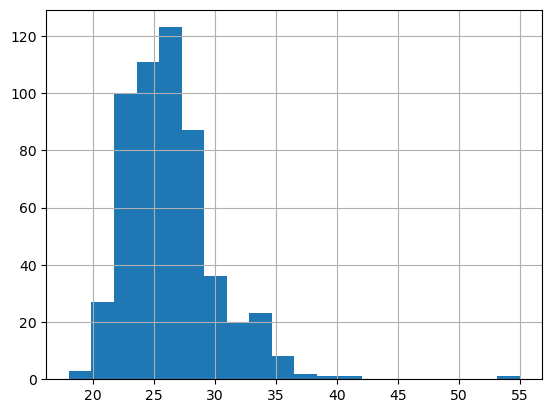

In [12]:
data.shape
data.drop(['id'], axis=1)
data.drop(['idg'], axis=1)
data.drop_duplicates(subset=['iid']).gender.value_counts()
data = data.drop(['round', 'position', 'order','field',
                  'partner', 'age_o', 'race_o', 'pf_o_att', 
                  'pf_o_sin', 'pf_o_int',
                  'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
                  'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
                  'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
                 axis=1)
data.drop_duplicates(subset=['iid']).age.hist(bins=20)
data = data.dropna(subset=['age'])
data.loc[:, 'field_cd'] = data.loc[:, 'field_cd'].fillna(19)
def mean_target_encoding(data, target, column):
    mean_enc = data.groupby(column)[target].mean()
    data[column+'_m_enc'] = data[column].map(mean_enc)
    return data
data = mean_target_encoding(data, 'match', 'field_cd')

1

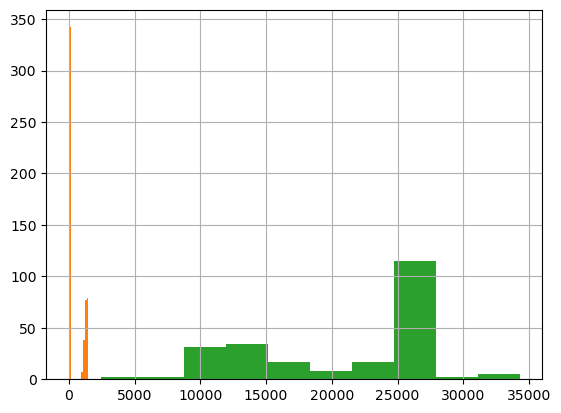

In [13]:
data.field_cd_m_enc
data = data.drop(['field_cd'], axis=1)
data = data.drop(['undergra'], axis=1)
data.loc[:, 'mn_sat'] = data.loc[:, 'mn_sat'].str.replace(',', '').astype(float)
data.drop_duplicates('iid').mn_sat.hist()
data['mn_sat'] = data['mn_sat'].fillna(0)
data.drop_duplicates('iid').mn_sat.hist()
data.loc[:, 'tuition'] = data.loc[:, 'tuition'].str.replace(',', '').astype(float)
data.drop_duplicates('iid').tuition.hist()
data['tuition'] = data['tuition'].fillna(-10000)
data = mean_target_encoding(data, 'match', 'race')
data = data.drop(['race'], axis=1)
data.drop_duplicates('iid').imprace.isnull().sum()

In [14]:
data.drop_duplicates('iid').imprelig.isnull().sum()

1

In [15]:
data = data.dropna(subset=['imprelig', 'imprace'])
data = data.drop(['from', 'zipcode'], axis=1)
data.loc[:, 'income'] = data.loc[:, 'income'].str.replace(',', '').astype(float)
data = data.drop(['income'], axis=1)
data = mean_target_encoding(data, 'match', 'goal')
data = mean_target_encoding(data, 'match', 'date')
data = mean_target_encoding(data, 'match', 'go_out')
data = data.drop(['goal'], axis=1)
data = data.drop(['date'], axis=1)
data = data.drop(['go_out'], axis=1)
data = mean_target_encoding(data, 'match', 'career_c')
data = data.drop(['career_c', 'career'], axis=1)
data = data.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)
data = data.drop(['expnum'], axis=1)
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = data.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
data.loc[:, 'temp_totalsum'] = data.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
data.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(data.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/data.loc[:, 'temp_totalsum'].T).T * 100
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = data.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
data.loc[:, 'temp_totalsum'] = data.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
data.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(data.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/data.loc[:, 'temp_totalsum'].T).T * 100
data = data.drop(['temp_totalsum'], axis=1)
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    data = data.drop(feat, axis=1)
data = data.drop('positin1', axis=1)
data = data.dropna(subset=['career_c_m_enc'])
data = data.drop(['id'], axis=1)
features = list(data.columns)
bad_features = list(filter(lambda x: x[-1].isnumeric() and int(x[-1]) > 1, features))
data = data.drop(bad_features, axis=1)
bad_features = list(filter(lambda x: x[-2:] == '_s', features))
#bad_features ['attr1_s','sinc1_s','intel1_s','fun1_s','amb1_s','shar1_s','attr3_s','sinc3_s','intel3_s','fun3_s','amb3_s']
data = data.drop(bad_features, axis=1)
data = data.drop(['you_call', 'them_cal'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8208 entries, 30 to 8377
Data columns (total 50 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iid             8208 non-null   int64  
 1   gender          8208 non-null   int64  
 2   idg             8208 non-null   int64  
 3   condtn          8208 non-null   int64  
 4   wave            8208 non-null   int64  
 5   pid             8199 non-null   float64
 6   match           8208 non-null   int64  
 7   int_corr        8130 non-null   float64
 8   samerace        8208 non-null   int64  
 9   age             8208 non-null   float64
 10  mn_sat          8208 non-null   float64
 11  tuition         8208 non-null   float64
 12  imprace         8208 non-null   float64
 13  imprelig        8208 non-null   float64
 14  exphappy        8208 non-null   float64
 15  attr1_1         8208 non-null   float64
 16  sinc1_1         8208 non-null   float64
 17  intel1_1        8208 non-null   

In [16]:
data = data.drop(['wave'], axis=1)

In [17]:
data = data.fillna(data.mean())

In [18]:
data_male = data.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
data_female = data.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
data_female.columns = data_female.columns + '_f'

In [19]:
data_female.index = data_female.iid_f
data_female

,iid_f,idg_f,condtn_f,pid_f,age_f,mn_sat_f,tuition_f,imprace_f,imprelig_f,exphappy_f,...,prob_f,met_f,match_es_f,length_f,field_cd_m_enc_f,race_m_enc_f,goal_m_enc_f,date_m_enc_f,go_out_m_enc_f,career_c_m_enc_f
iid_f,,,,,,,,,,,,,,,,,,,,,
4,4,7,1,11.0,23.0,0.0,-10000.0,1.0,1.0,1.0,...,7.0,2.0,2.000000,3.000000,0.204511,0.166986,0.170975,0.155105,0.194253,0.198519
5,5,9,1,11.0,21.0,0.0,-10000.0,8.0,1.0,7.0,...,5.0,2.0,3.212421,2.000000,0.204511,0.166986,0.160691,0.178922,0.194253,0.198519
6,6,11,1,11.0,23.0,0.0,-10000.0,1.0,1.0,4.0,...,6.0,2.0,4.000000,3.000000,0.204511,0.134712,0.170975,0.206391,0.194253,0.198519
7,7,13,1,11.0,22.0,0.0,-10000.0,2.0,4.0,7.0,...,4.0,2.0,2.000000,1.836515,0.204511,0.134712,0.170975,0.155105,0.194253,0.198519
8,8,15,1,11.0,25.0,0.0,-10000.0,1.0,1.0,6.0,...,5.0,2.0,3.212421,1.836515,0.167842,0.166986,0.170975,0.155105,0.194253,0.162393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,35,2,531.0,26.0,1188.0,11311.0,5.0,2.0,6.0,...,1.0,0.0,2.000000,2.000000,0.106838,0.185241,0.170975,0.155105,0.147499,0.159091
527,527,37,2,531.0,24.0,1290.0,15309.0,5.0,5.0,1.0,...,3.0,0.0,0.000000,1.000000,0.106838,0.197318,0.170975,0.178922,0.147499,0.159091
528,528,39,2,531.0,29.0,1310.0,33585.0,8.0,7.0,4.0,...,1.0,0.0,2.000000,1.000000,0.106838,0.185241,0.160691,0.141834,0.194253,0.159091


In [20]:
data_male.index = data_male.iid
data_male

,iid,idg,condtn,pid,match,int_corr,samerace,age,mn_sat,tuition,...,prob,met,match_es,length,field_cd_m_enc,race_m_enc,goal_m_enc,date_m_enc,go_out_m_enc,career_c_m_enc
iid,,,,,,,,,,,,,,,,,,,,,
11,11,2,1,1.0,0,0.14,0,27.0,0.0,-10000.0,...,4.0,2.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
11,11,2,1,2.0,0,0.29,1,27.0,0.0,-10000.0,...,2.0,2.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
11,11,2,1,3.0,0,-0.24,1,27.0,0.0,-10000.0,...,2.0,1.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
11,11,2,1,4.0,0,-0.18,1,27.0,0.0,-10000.0,...,3.0,2.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
11,11,2,1,5.0,0,-0.43,1,27.0,0.0,-10000.0,...,5.0,2.0,0.0,2.0,0.174935,0.166986,0.170975,0.155105,0.126667,0.155172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,552,44,2,526.0,0,0.64,0,25.0,0.0,-10000.0,...,5.0,0.0,3.0,1.0,0.153846,0.166986,0.170975,0.211039,0.194253,0.168831
552,552,44,2,527.0,0,0.71,0,25.0,0.0,-10000.0,...,4.0,0.0,3.0,1.0,0.153846,0.166986,0.170975,0.211039,0.194253,0.168831
552,552,44,2,528.0,0,-0.46,0,25.0,0.0,-10000.0,...,5.0,0.0,3.0,1.0,0.153846,0.166986,0.170975,0.211039,0.194253,0.168831


In [21]:
data_femaile = data_female.astype({'pid_f':'int'})
data_male = data_male.astype({'pid':'int'})
join_data = data_male.join(data_female, on='pid')
join_data = join_data.dropna()
join_data

,iid,idg,condtn,pid,match,int_corr,samerace,age,mn_sat,tuition,...,prob_f,met_f,match_es_f,length_f,field_cd_m_enc_f,race_m_enc_f,goal_m_enc_f,date_m_enc_f,go_out_m_enc_f,career_c_m_enc_f
iid,,,,,,,,,,,,,,,,,,,,,
11,11,2,1,4,0,-0.18,1,27.0,0.0,-10000.0,...,7.0,2.0,2.000000,3.000000,0.204511,0.166986,0.170975,0.155105,0.194253,0.198519
11,11,2,1,5,0,-0.43,1,27.0,0.0,-10000.0,...,5.0,2.0,3.212421,2.000000,0.204511,0.166986,0.160691,0.178922,0.194253,0.198519
11,11,2,1,6,0,0.33,0,27.0,0.0,-10000.0,...,6.0,2.0,4.000000,3.000000,0.204511,0.134712,0.170975,0.206391,0.194253,0.198519
11,11,2,1,7,0,0.19,0,27.0,0.0,-10000.0,...,4.0,2.0,2.000000,1.836515,0.204511,0.134712,0.170975,0.155105,0.194253,0.198519
11,11,2,1,8,0,-0.03,1,27.0,0.0,-10000.0,...,5.0,2.0,3.212421,1.836515,0.167842,0.166986,0.170975,0.155105,0.194253,0.162393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,552,44,2,526,0,0.64,0,25.0,0.0,-10000.0,...,1.0,0.0,2.000000,2.000000,0.106838,0.185241,0.170975,0.155105,0.147499,0.159091
552,552,44,2,527,0,0.71,0,25.0,0.0,-10000.0,...,3.0,0.0,0.000000,1.000000,0.106838,0.197318,0.170975,0.178922,0.147499,0.159091
552,552,44,2,528,0,-0.46,0,25.0,0.0,-10000.0,...,1.0,0.0,2.000000,1.000000,0.106838,0.185241,0.160691,0.141834,0.194253,0.159091


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [22]:
X = join_data.drop(['match'], axis=1)
y = join_data.match

In [23]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([3353,  664], dtype=int64))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [26]:
# Поиск оптимального критерия информативности
criterions = ['gini', 'misclass', 'entropy']
criterion_scores = []
criterion_scores_train = []

for c in criterions:
    dates_clf = MyDecisionTreeClassifier(criterion=c)#, max_depth=best_max_depth, min_samples_split=best_min_samples_split)
    dates_clf.fit(X_train, y_train)
    prediction = dates_clf.predict(X_test)
    acc_test = accuracy_score(prediction, y_test)
    criterion_scores.append(acc_test)
    prediction = dates_clf.predict(X_train)
    acc = accuracy_score(prediction, y_train)
    criterion_scores_train.append(acc)
    print(f"criterion: {c:<8}  train: {round(acc,5)}  test: {round(acc_test,5)}")

criterion: gini      train: 0.84418  test: 0.82007
criterion: misclass  train: 0.84845  test: 0.82836
criterion: entropy   train: 0.84134  test: 0.82338


In [27]:
#Самый лучший критерий - misclass 
best_criterion='misclass'

In [28]:
min_splits = [i for i in range(1, 26)]
min_splits_scores = []
for s in min_splits:
    dates_clf = MyDecisionTreeClassifier(criterion=best_criterion, min_samples_split=s)
    dates_clf.fit(X_train, y_train)
    prediction = dates_clf.predict(X_test)
    acc_test = accuracy_score(prediction, y_test)
    prediction = dates_clf.predict(X_train)
    acc = accuracy_score(prediction, y_train)
    min_splits_scores.append((acc, acc_test))
    print(f"splits: {s:<2}  train: {round(acc,5)}  test: {round(acc_test,5)}")

splits: 1   train: 0.84845  test: 0.82836
splits: 2   train: 0.84845  test: 0.82836
splits: 3   train: 0.84845  test: 0.82836
splits: 4   train: 0.84845  test: 0.82836
splits: 5   train: 0.84703  test: 0.82753
splits: 6   train: 0.84703  test: 0.82753
splits: 7   train: 0.84703  test: 0.82753
splits: 8   train: 0.84703  test: 0.82753
splits: 9   train: 0.84703  test: 0.82753
splits: 10  train: 0.84703  test: 0.82753
splits: 11  train: 0.84703  test: 0.82753
splits: 12  train: 0.84703  test: 0.82753
splits: 13  train: 0.84276  test: 0.81509
splits: 14  train: 0.84276  test: 0.81509
splits: 15  train: 0.84276  test: 0.81509
splits: 16  train: 0.84276  test: 0.81509
splits: 17  train: 0.8392  test: 0.80846
splits: 18  train: 0.8392  test: 0.80846
splits: 19  train: 0.8392  test: 0.80846
splits: 20  train: 0.8392  test: 0.80846
splits: 21  train: 0.8392  test: 0.80846
splits: 22  train: 0.8392  test: 0.80846
splits: 23  train: 0.8392  test: 0.80846
splits: 24  train: 0.8392  test: 0.80846


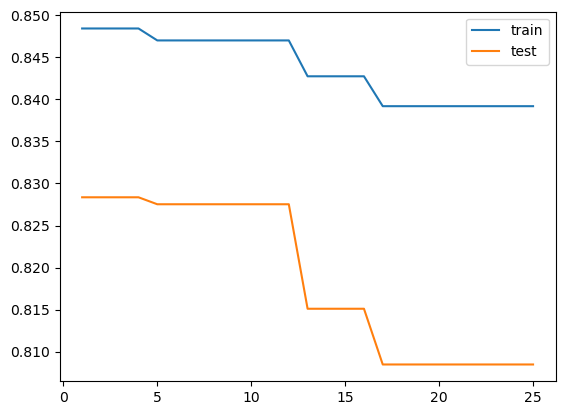

In [29]:
import matplotlib.pyplot as plt
plt.plot(min_splits, min_splits_scores)
plt.legend(['train', 'test'])

In [30]:
# На валидации лучшее значение при сплите от 1 до 4
best_min_samples_split = 4

In [31]:
max_depths = range(1, 21)
max_depths_scores = []
for d in max_depths:
    dates_clf = MyDecisionTreeClassifier(criterion=best_criterion, max_depth=d)
    dates_clf.fit(X_train, y_train)
    prediction = dates_clf.predict(X_test)
    acc_test = accuracy_score(prediction, y_test)
    prediction = dates_clf.predict(X_train)
    acc = accuracy_score(prediction, y_train)
    max_depths_scores.append((acc, acc_test))
    print(f"depth: {d:<2}  train: {round(acc,5):<7}  test: {round(acc_test,5)}")

depth: 1   train: 0.83885  test: 0.81343
depth: 2   train: 0.84312  test: 0.82587
depth: 3   train: 0.84347  test: 0.8209
depth: 4   train: 0.84703  test: 0.82753
depth: 5   train: 0.84845  test: 0.82836
depth: 6   train: 0.85521  test: 0.82504
depth: 7   train: 0.86304  test: 0.82504
depth: 8   train: 0.85237  test: 0.83167
depth: 9   train: 0.85308  test: 0.83167
depth: 10  train: 0.85308  test: 0.83167
depth: 11  train: 0.85308  test: 0.83167
depth: 12  train: 0.85308  test: 0.83167
depth: 13  train: 0.85308  test: 0.83167
depth: 14  train: 0.85308  test: 0.83167
depth: 15  train: 0.85308  test: 0.83167
depth: 16  train: 0.85308  test: 0.83167
depth: 17  train: 0.85308  test: 0.83167
depth: 18  train: 0.85308  test: 0.83167
depth: 19  train: 0.85308  test: 0.83167
depth: 20  train: 0.85308  test: 0.83167


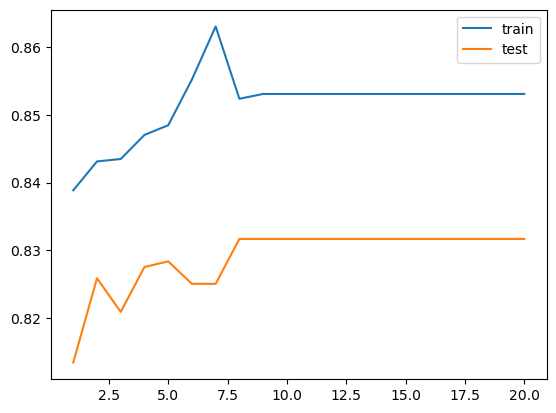

In [32]:
plt.plot(max_depths, max_depths_scores)
plt.legend(['train', 'test'])

In [33]:
# Берем max_depth равное 4, так как в этой точке имеется небольшой всплеск на валидации
best_max_depth = 8

In [34]:
best_clf = MyDecisionTreeClassifier(min_samples_split=best_min_samples_split, max_depth=best_max_depth, criterion=best_criterion)
best_clf.fit(X_train, y_train)
best_prediction = best_clf.predict(X_test)
best_acc = accuracy_score(best_prediction, y_test)
# Максимальная точность, которой удалось достичь: 0.8333333333333334
best_acc

0.8250414593698175

In [35]:
best_clf.tree

{0: (0, 37, 10.0),
 1: (0, 0, 225.0),
 3: (0, 37, 9.0),
 7: (0, 0, 100.0),
 15: (0, 0, 48.0),
 31: (0, 24, 9.0),
 63: (0, 0, 43.0),
 127: (0, 75, 8.0),
 255: (1, 0, 0.9574468085106383),
 256: (1, 0, 0.6),
 128: (1, 0, 0.9016393442622951),
 64: (0, 4, 0.125),
 129: (1, 1, 1.0),
 130: (1, 0, 0.8),
 32: (1, 0, 0.8857142857142857),
 16: (0, 31, 10.0),
 33: (1, 0, 0.8448598130841122),
 34: (0, 84, 3.212420517168296),
 69: (0, 0, 109.0),
 139: (1, 0, 0.8571428571428571),
 140: (1, 0, 0.7894736842105263),
 70: (0, 44, 0.17892156862745098),
 141: (1, 0, 0.75),
 142: (1, 1, 0.75),
 8: (0, 59, 19.049999999999997),
 17: (0, 0, 185.0),
 35: (1, 0, 0.6666666666666666),
 36: (1, 0, 0.9),
 18: (0, 29, 0.5),
 37: (1, 0, 1.0),
 38: (1, 1, 0.9411764705882353),
 4: (0, 29, 1.0),
 9: (0, 0, 544.0),
 19: (0, 0, 365.0),
 39: (0, 0, 248.0),
 79: (0, 0, 245.0),
 159: (0, 0, 229.0),
 319: (1, 0, 1.0),
 320: (1, 0, 1.0),
 160: (1, 0, 1.0),
 80: (1, 0, 1.0),
 40: (1, 0, 1.0),
 20: (1, 0, 1.0),
 10: (0, 89, 0.211

In [36]:
np.unique(best_prediction, return_counts=True)

(array([0, 1], dtype=int64), array([1128,   78], dtype=int64))

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн. 
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации? 

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

<BarContainer object of 92 artists>

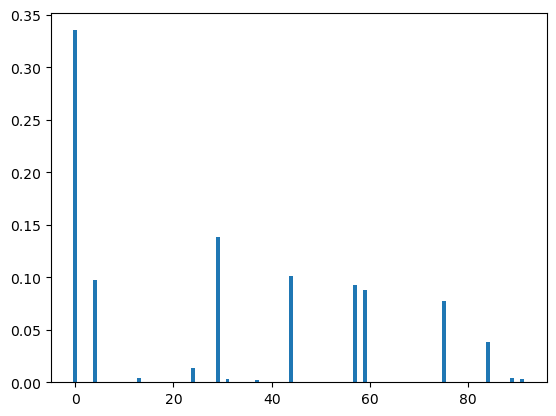

In [37]:
imps = best_clf.get_feature_importance()
plt.bar(range(imps.shape[0]), imps)

In [38]:
#imps = np.array(imps)
print("10 main features:", [(i,imps[i]) for i in np.argsort(imps)[::-1][0:10]])

10 main features: [(0, 0.33499658012463107), (29, 0.13808915216680756), (44, 0.10157642842276332), (4, 0.0975133712858528), (57, 0.09286987741509788), (59, 0.08784988404130882), (75, 0.07751062845798552), (84, 0.0386957822562908), (24, 0.013213193941172485), (89, 0.004531673359291839)]


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

